In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import requests
from PIL import Image
from io import BytesIO
import os

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [2]:
bp_track = pd.read_csv('data/bp_track.csv')

C:\Users\Shank\AppData\Local\Temp\ipykernel_15240\1573399701.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  bp_track = pd.read_csv('data/bp_track.csv')


In [3]:
bp_track_media = pd.read_csv('data/bp_track_media.csv')

In [4]:
bp_genre = pd.read_csv('data/bp_genre.csv')

In [5]:
# Perform the merge to add only 'genre_id' from bp_track to bp_track_media
bp_media = pd.merge(bp_track_media, bp_track[['track_id', 'genre_id']], on='track_id', how='inner')

# Display the first few rows to verify
bp_media.head()

,track_id,wave_img_id,wave_img_uuid,sample_uuid,sample_start,sample_end,updated_on,genre_id
0,17767172,34401296.0,09d00050-0a43-42f1-bb6e-c22bf9591a80,09d00050-0a43-42f1-bb6e-c22bf9591a80,172732.0,292732.0,2023-09-14 16:19:56,99
1,17775434,34430784.0,b9509b0f-2b7d-4254-84df-cc53eded7904,b9509b0f-2b7d-4254-84df-cc53eded7904,163532.0,283532.0,2023-09-14 16:19:56,99
2,17800962,34520332.0,a9519a6a-a7cf-4a9e-aa55-b1b0ea80870b,a9519a6a-a7cf-4a9e-aa55-b1b0ea80870b,157108.0,277108.0,2023-09-14 16:19:56,99
3,17610335,33799612.0,93747c55-cfb1-4df5-9c6a-ce9f5751983f,93747c55-cfb1-4df5-9c6a-ce9f5751983f,162976.0,282976.0,2023-09-14 16:19:56,99
4,17610338,33799613.0,e104a0f7-dfb7-4e10-8ed3-056e018c9775,e104a0f7-dfb7-4e10-8ed3-056e018c9775,174826.0,294826.0,2023-09-14 16:19:56,99


In [6]:
# Assuming bp_media contains the genre_id and you want to replace it with genre_name

# Merge bp_media with bp_genre on 'genre_id'
bp_media = pd.merge(bp_media, bp_genre[['genre_id', 'genre_name']], on='genre_id', how='left')

# Optionally, drop 'genre_id' if you no longer need it
bp_media.drop('genre_id', axis=1, inplace=True)

In [7]:
bp_media.isnull().sum()


track_id             0
wave_img_id      15834
wave_img_uuid    15834
sample_uuid          0
sample_start      2872
sample_end        2872
updated_on           0
genre_name           0
dtype: int64

In [8]:
bp_media.dropna(inplace=True)

__________

# Default Genres

In [9]:
sampled_data = bp_media.sample(n=1000, random_state=42)

In [10]:
# Function to download and process images from URLs, and collect error IDs
def load_images_from_url(df, img_column, target_size=(360, 60)):
    images = []
    failed_images = []  # List to store IDs of failed image downloads
    base_url = "https://geo-media.beatport.com/image_size/1500x250/"  # Replace with actual base URL if needed
    
    for img_id in df[img_column]:
        # Construct full image URL
        img_url = f"{base_url}{img_id}.png"
        try:
            # Send a request to download the image
            response = requests.get(img_url)
            response.raise_for_status()  # Raise an exception for failed requests

            # Open the image from the response content
            img = Image.open(BytesIO(response.content)).convert('RGB')  # Convert to RGB
            img = img.resize(target_size)  # Resize to the target size
            img_array = np.array(img)
            images.append(img_array)
        except Exception as e:
            print(f"Error loading image {img_id}: {e}")
            failed_images.append(img_id)  # Add the image ID to the failed list
    
    return np.array(images), failed_images

# Load images from URLs using the wave_img_uuid or wave_img_id
image_data, failed_image_ids = load_images_from_url(sampled_data, 'wave_img_uuid')

# Check which images failed to load
if failed_image_ids:
    print(f"The following images failed to load: {failed_image_ids}")
else:
    print("All images loaded successfully.")


Error loading image f982da5d-dbee-46f5-839c-bcb0ec6e4be4: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/f982da5d-dbee-46f5-839c-bcb0ec6e4be4.png
Error loading image 17a1fd27-a3e8-4900-b9f5-22509a097451: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/17a1fd27-a3e8-4900-b9f5-22509a097451.png
Error loading image b7dab5ad-3d3e-4d56-82cd-dd3e46ff8508: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/b7dab5ad-3d3e-4d56-82cd-dd3e46ff8508.png
Error loading image eca24c26-7311-477a-8f1f-02f2b7ee9d6e: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/eca24c26-7311-477a-8f1f-02f2b7ee9d6e.png
Error loading image bbabbb81-42d8-4881-a7ff-c75a74214fb0: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/bbabbb81-42d8-4881-a7ff-c75a74214fb0.png
The following images failed to load: ['f982da5d-dbee-46f5-839c-bc

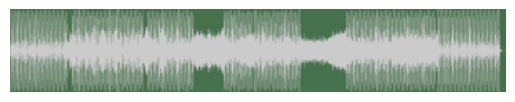

In [11]:
# Get the image at the specified index
img = image_data[36]

# Display the image using matplotlib
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

In [12]:
# Normalize the image data
image_data = image_data / 255.0

In [13]:
# Check how many unique genres you have in the dataset
print(sampled_data['genre_name'].nunique())

# Check the distribution of genre IDs
print(sampled_data['genre_name'].value_counts())

31
genre_name
Electronica                             147
House                                   112
Techno (Peak Time / Driving)             96
Deep House                               93
Tech House                               92
Progressive House                        59
Drum & Bass                              46
Minimal / Deep Tech                      45
Dance / Electro Pop                      41
Trance (Main Floor)                      40
Mainstage                                34
Trap / Wave                              26
Psy-Trance                               20
Breaks / Breakbeat / UK Bass             19
Hard Dance / Hardcore                    18
Melodic House & Techno                   17
Nu Disco / Disco                         16
Indie Dance                              15
Dubstep                                  12
Organic House / Downtempo                10
Funky House                               8
Afro House                                7
UK Garage / Bassli

In [14]:
# Step 1: Label encode the genre names to convert them to numeric form
label_encoder = LabelEncoder()
genre_labels_encoded = label_encoder.fit_transform(sampled_data['genre_name'][:len(image_data)])

# Step 2: One-hot encode the numeric genre labels
num_classes = len(label_encoder.classes_)  # Get the number of unique genres
target_labels = to_categorical(genre_labels_encoded, num_classes=num_classes)

In [15]:
print(f"Number of images: {len(image_data)}")
print(f"Number of labels: {len(target_labels)}")

Number of images: 995
Number of labels: 995


In [16]:
X_train, X_test, y_train, y_test = train_test_split(image_data, target_labels, test_size=0.2, random_state=42)

# Check the shapes of the resulting datasets
print(f"Training set shape (X_train): {X_train.shape}")
print(f"Training labels shape (y_train): {y_train.shape}")
print(f"Testing set shape (X_test): {X_test.shape}")
print(f"Testing labels shape (y_test): {y_test.shape}")

Training set shape (X_train): (796, 60, 360, 3)
Training labels shape (y_train): (796, 31)
Testing set shape (X_test): (199, 60, 360, 3)
Testing labels shape (y_test): (199, 31)


In [17]:
model = Sequential()

# First Convolutional Block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(60, 360, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Block (increased filters)
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Block (increased filters)
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fourth Convolutional Block (newly added, with more filters)
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the data for Dense layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(256, activation='relu'))  # Increased units in Dense layer
model.add(Dropout(0.5))  # Keeping Dropout to prevent overfitting

# Output layer (softmax for multi-class classification)
model.add(Dense(len(sampled_data['genre_name'].unique()), activation='softmax'))

In [18]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
model_checkpoint = ModelCheckpoint('best_model_image.h5', monitor='val_loss', save_best_only=True)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with callbacks
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=15, callbacks=[early_stopping, reduce_lr, model_checkpoint])

Epoch 1/100
54/54 [==============================] - 7s 121ms/step - loss: 3.0598 - accuracy: 0.1269 - val_loss: 2.9644 - val_accuracy: 0.1055 - lr: 0.0010
Epoch 2/100
54/54 [==============================] - 6s 113ms/step - loss: 2.9538 - accuracy: 0.1168 - val_loss: 3.0074 - val_accuracy: 0.1055 - lr: 0.0010
Epoch 3/100
54/54 [==============================] - 7s 127ms/step - loss: 2.9848 - accuracy: 0.1357 - val_loss: 2.9618 - val_accuracy: 0.1055 - lr: 0.0010
Epoch 4/100
54/54 [==============================] - 6s 111ms/step - loss: 2.9198 - accuracy: 0.1369 - val_loss: 2.9399 - val_accuracy: 0.1055 - lr: 0.0010
Epoch 5/100
54/54 [==============================] - 6s 113ms/step - loss: 2.9202 - accuracy: 0.1558 - val_loss: 2.9359 - val_accuracy: 0.1055 - lr: 0.0010
Epoch 6/100
54/54 [==============================] - 6s 105ms/step - loss: 2.9087 - accuracy: 0.1394 - val_loss: 2.9609 - val_accuracy: 0.1055 - lr: 0.0010
Epoch 7/100
54/54 [==============================] - 6s 118ms/st

In [19]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

7/7 [==============================] - 1s 52ms/step - loss: 2.9332 - accuracy: 0.1055
Test Accuracy: 0.10552763938903809


_____________

# Manual Grouping

In [20]:
genre_mapping = {
    # House Group
    'House': 'House',
    'Tech House': 'House',
    'Deep House': 'House',
    'Progressive House': 'House',
    'Funky House': 'House',
    'Jackin House': 'House',
    'Afro House': 'House',
    'Bass House': 'House',

    # Techno Group
    'Techno (Peak Time / Driving)': 'Techno',
    'Techno (Raw / Deep / Hypnotic)': 'Techno',
    'Minimal / Deep Tech': 'Techno',
    'Melodic House & Techno': 'Techno',
    'Hard Techno': 'Techno',

    # Trance Group
    'Trance (Main Floor)': 'Trance',
    'Psy-Trance': 'Trance',
    'Trance (Raw / Deep / Hypnotic)': 'Trance',

    # Bass Music Group
    'Drum & Bass': 'Bass Music',
    'Dubstep': 'Bass Music',
    '140 / Deep Dubstep / Grime': 'Bass Music',
    'Trap / Wave': 'Bass Music',
    'Breaks / Breakbeat / UK Bass': 'Bass Music',
    'Bass / Club': 'Bass Music',
    'UK Garage / Bassline': 'Bass Music',

    # Hard Dance & Hardcore Group
    'Hard Dance / Hardcore': 'Hard Dance & Hardcore',

    # Dance/Pop Group
    'Mainstage': 'Dance/Pop',
    'Dance / Electro Pop': 'Dance/Pop',
    'Nu Disco / Disco': 'Dance/Pop',

    # Downtempo & World Group
    'Organic House / Downtempo': 'Downtempo & World',
    'Amapiano': 'Downtempo & World',

    # Experimental & Indie Group
    'Electronica': 'Experimental & Indie',
    'Indie Dance': 'Experimental & Indie',
    'Electro (Classic / Detroit / Modern)': 'Experimental & Indie'
}


In [21]:
# Assuming your DataFrame is df and it has a column 'genre_name'
bp_genre['broad_genre'] = bp_genre['genre_name'].map(genre_mapping)

                              genre_name            broad_genre
0                  Hard Dance / Hardcore  Hard Dance & Hardcore
1                       Nu Disco / Disco              Dance/Pop
2                             Deep House                  House
3                            Bass / Club             Bass Music
4   Electro (Classic / Detroit / Modern)   Experimental & Indie
5                            Hard Techno                 Techno
6                                Dubstep             Bass Music
7             140 / Deep Dubstep / Grime             Bass Music
8                            Funky House                  House
9                      Progressive House                  House
10             Organic House / Downtempo      Downtempo & World
11                           Indie Dance   Experimental & Indie
12                            Afro House                  House
13                   Minimal / Deep Tech                 Techno
14                             Mainstage

In [23]:
# Perform the merge to add only 'genre_id' from bp_track to bp_track_media
bp_media = pd.merge(bp_track_media, bp_track[['track_id', 'genre_id']], on='track_id', how='inner')

,track_id,wave_img_id,wave_img_uuid,sample_uuid,sample_start,sample_end,updated_on,genre_id
0,17767172,34401296.0,09d00050-0a43-42f1-bb6e-c22bf9591a80,09d00050-0a43-42f1-bb6e-c22bf9591a80,172732.0,292732.0,2023-09-14 16:19:56,99
1,17775434,34430784.0,b9509b0f-2b7d-4254-84df-cc53eded7904,b9509b0f-2b7d-4254-84df-cc53eded7904,163532.0,283532.0,2023-09-14 16:19:56,99
2,17800962,34520332.0,a9519a6a-a7cf-4a9e-aa55-b1b0ea80870b,a9519a6a-a7cf-4a9e-aa55-b1b0ea80870b,157108.0,277108.0,2023-09-14 16:19:56,99
3,17610335,33799612.0,93747c55-cfb1-4df5-9c6a-ce9f5751983f,93747c55-cfb1-4df5-9c6a-ce9f5751983f,162976.0,282976.0,2023-09-14 16:19:56,99
4,17610338,33799613.0,e104a0f7-dfb7-4e10-8ed3-056e018c9775,e104a0f7-dfb7-4e10-8ed3-056e018c9775,174826.0,294826.0,2023-09-14 16:19:56,99


In [24]:
# Merge bp_media with bp_genre on 'genre_id'
bp_media = pd.merge(bp_media, bp_genre[['genre_id', 'broad_genre']], on='genre_id', how='left')

# Optionally, drop 'genre_id' if you no longer need it
bp_media.drop('genre_id', axis=1, inplace=True)

In [25]:
bp_media.isnull().sum()


track_id             0
wave_img_id      15834
wave_img_uuid    15834
sample_uuid          0
sample_start      2872
sample_end        2872
updated_on           0
broad_genre          0
dtype: int64

In [26]:
bp_media.dropna(inplace=True)

In [27]:
sampled_data = bp_media.sample(n=1000, random_state=42)

In [28]:
# Load images from URLs using the wave_img_uuid or wave_img_id
image_data, failed_image_ids = load_images_from_url(sampled_data, 'wave_img_uuid')


Error loading image f982da5d-dbee-46f5-839c-bcb0ec6e4be4: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/f982da5d-dbee-46f5-839c-bcb0ec6e4be4.png
Error loading image 17a1fd27-a3e8-4900-b9f5-22509a097451: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/17a1fd27-a3e8-4900-b9f5-22509a097451.png
Error loading image b7dab5ad-3d3e-4d56-82cd-dd3e46ff8508: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/b7dab5ad-3d3e-4d56-82cd-dd3e46ff8508.png
Error loading image eca24c26-7311-477a-8f1f-02f2b7ee9d6e: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/eca24c26-7311-477a-8f1f-02f2b7ee9d6e.png
Error loading image bbabbb81-42d8-4881-a7ff-c75a74214fb0: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/bbabbb81-42d8-4881-a7ff-c75a74214fb0.png
The following images failed to load: ['f982da5d-dbee-46f5-839c-bc

In [30]:
# Normalize the image data
image_data = image_data / 255.0

In [31]:
# Check how many unique genres you have in the dataset
print(sampled_data['broad_genre'].nunique())

# Check the distribution of genre IDs
print(sampled_data['broad_genre'].value_counts())

8
broad_genre
House                    378
Techno                   165
Experimental & Indie     165
Bass Music               112
Dance/Pop                 91
Trance                    60
Hard Dance & Hardcore     18
Downtempo & World         11
Name: count, dtype: int64


In [32]:
# Step 1: Label encode the genre names to convert them to numeric form
label_encoder = LabelEncoder()
genre_labels_encoded = label_encoder.fit_transform(sampled_data['broad_genre'][:len(image_data)])

# Step 2: One-hot encode the numeric genre labels
num_classes = len(label_encoder.classes_)  # Get the number of unique genres
target_labels = to_categorical(genre_labels_encoded, num_classes=num_classes)



In [33]:
print(f"Number of images: {len(image_data)}")
print(f"Number of labels: {len(target_labels)}")

Number of images: 995
Number of labels: 995


In [34]:
X_train, X_test, y_train, y_test = train_test_split(image_data, target_labels, test_size=0.2, random_state=42)

# Check the shapes of the resulting datasets
print(f"Training set shape (X_train): {X_train.shape}")
print(f"Training labels shape (y_train): {y_train.shape}")
print(f"Testing set shape (X_test): {X_test.shape}")
print(f"Testing labels shape (y_test): {y_test.shape}")


Training set shape (X_train): (796, 60, 360, 3)
Training labels shape (y_train): (796, 8)
Testing set shape (X_test): (199, 60, 360, 3)
Testing labels shape (y_test): (199, 8)


In [36]:
model = Sequential()

# First Convolutional Block
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(60, 360, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Block
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Block
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the data for Dense layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer (softmax for multi-class classification)
model.add(Dense(len(sampled_data['broad_genre'].unique()), activation='softmax'))

In [37]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=0.00001)
model_checkpoint = ModelCheckpoint('best_model_image.h5', monitor='val_accuracy', save_best_only=True)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with callbacks
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=15, callbacks=[early_stopping, reduce_lr, model_checkpoint])

Epoch 1/100
43/43 [==============================] - 4s 75ms/step - loss: 1.9176 - accuracy: 0.3412 - val_loss: 1.8125 - val_accuracy: 0.3250 - lr: 0.0010
Epoch 2/100
43/43 [==============================] - 2s 46ms/step - loss: 1.8290 - accuracy: 0.3648 - val_loss: 1.7931 - val_accuracy: 0.3250 - lr: 0.0010
Epoch 3/100
43/43 [==============================] - 2s 51ms/step - loss: 1.8057 - accuracy: 0.3695 - val_loss: 1.7816 - val_accuracy: 0.3250 - lr: 0.0010
Epoch 4/100
43/43 [==============================] - 2s 41ms/step - loss: 1.7947 - accuracy: 0.3774 - val_loss: 1.7823 - val_accuracy: 0.3250 - lr: 0.0010
Epoch 5/100
43/43 [==============================] - 3s 66ms/step - loss: 1.7991 - accuracy: 0.3679 - val_loss: 1.7755 - val_accuracy: 0.3250 - lr: 0.0010
Epoch 6/100
43/43 [==============================] - 3s 67ms/step - loss: 1.7699 - accuracy: 0.3789 - val_loss: 1.7858 - val_accuracy: 0.3250 - lr: 0.0010
Epoch 7/100
43/43 [==============================] - 2s 51ms/step - lo

In [38]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

7/7 [==============================] - 0s 28ms/step - loss: 1.7661 - accuracy: 0.4121
Test Accuracy: 0.41206029057502747


___________

# KMeans Clustering

In [45]:
sampled_data = bp_media.sample(n=1000, random_state=42)

# Load images from URLs using the wave_img_uuid or wave_img_id
image_data, failed_image_ids = load_images_from_url(sampled_data, 'wave_img_uuid')

Error loading image f982da5d-dbee-46f5-839c-bcb0ec6e4be4: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/f982da5d-dbee-46f5-839c-bcb0ec6e4be4.png
Error loading image 17a1fd27-a3e8-4900-b9f5-22509a097451: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/17a1fd27-a3e8-4900-b9f5-22509a097451.png
Error loading image b7dab5ad-3d3e-4d56-82cd-dd3e46ff8508: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/b7dab5ad-3d3e-4d56-82cd-dd3e46ff8508.png
Error loading image eca24c26-7311-477a-8f1f-02f2b7ee9d6e: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/eca24c26-7311-477a-8f1f-02f2b7ee9d6e.png
Error loading image bbabbb81-42d8-4881-a7ff-c75a74214fb0: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/bbabbb81-42d8-4881-a7ff-c75a74214fb0.png


In [46]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load the VGG16 model without the top classification layer
model = VGG16(weights='imagenet', include_top=False, input_shape=(60, 360, 3))

features_list = []

# Iterate over each image in the 'image_data' array
for img_array in image_data:
    # Normalize pixel values if needed (assuming they're already loaded between 0-255)
    img_array = img_array / 255.0
    
    # Add batch dimension and preprocess for VGG16
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = preprocess_input(img_array)
    
    # Extract features using the model
    features = model.predict(img_array)
    features = features.flatten()  # Flatten the features to a 1D array
    
    # Append features to the list
    features_list.append(features)

# Convert the list to a numpy array for clustering
features_list = np.array(features_list)


1/1 [==============================] - 0s 70ms/step


c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMe

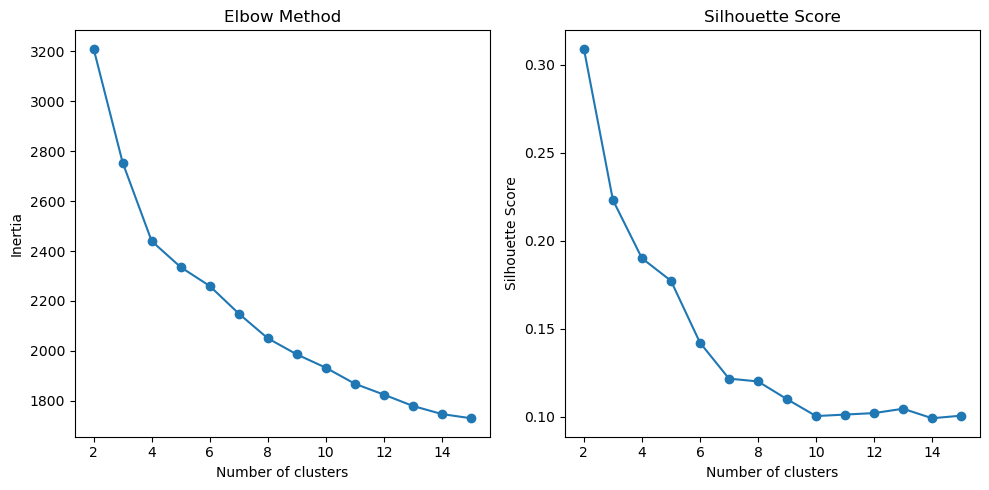

In [47]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# List to store inertia values for the Elbow Method and Silhouette Scores
inertia = []
sil_scores = []

# Range of cluster numbers to test (2 to 15 clusters, for example)
cluster_range = range(2, 16)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features_list)
    
    # Append the inertia (sum of squared distances) for the Elbow Method
    inertia.append(kmeans.inertia_)
    
    # Predict cluster labels and calculate silhouette score
    cluster_labels = kmeans.predict(features_list)
    sil_score = silhouette_score(features_list, cluster_labels)
    sil_scores.append(sil_score)

# Plot the Elbow Method
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

# Plot the Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(cluster_range, sil_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


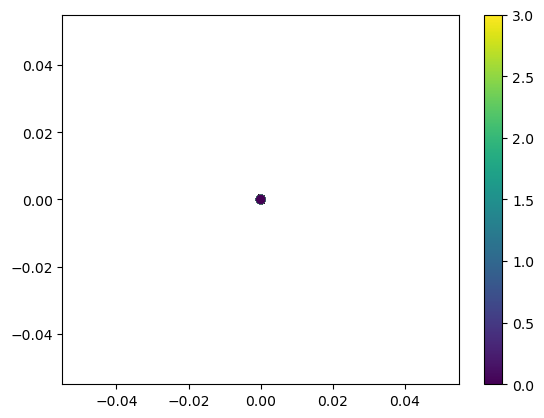

In [48]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming 'features_list' is a list of feature vectors for all images
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(features_list)

# Visualize or check cluster assignments
plt.scatter(features_list[:, 0], features_list[:, 1], c=clusters, cmap='viridis')
plt.colorbar()
plt.show()
